## Sorrento Marina
**Progetto di Machine Learning per il corso di Fondamenti di Intelligenza Artificiale**

Il seguente è uno script Python che suggerisce all'utente, basandosi su domande precedentemente poste, 
una possibile insieme di lidi balneari che potrebbero piacergli. L'obiettivo è quello di creare cluster di persone con interessi simili e consigliare nel modo più ottimale possibile.
Il dataset preso in esame presenta 145 istanze, dati raccolti attraverso un questionario da noi precedentemente creato.

In [1]:
#import di tutte le variabili che ci serviranno
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn import metrics
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
#legge il dataset e mostra i primi 5 elementi e la sua dimensionalità
#df = dataframe
df = pd.read_csv("C:\\fiaProject\dataset_turisti.txt", encoding='latin1')
df.head(5)
print('Tupla che rappresenta la dimensionalità del DataFrame:')
df.shape

,Anni,Sesso,SituazioneSentim,Figli,Lavoro,Ombrelloni,Ristorante,Palestra,CampiDaGioco,WiFi,...,Parcheggio,Animazione,AttivitaDiGruppo,Docce,Canoa,Prezzi,Vicinanza,Servizi,Meteo,Affluenza
0,15.21,m,Fidanzata/o,n,Studente/essa,0,0,0,1,1,...,1,0,0,1,0,1,1,1,1,0.0
1,15.21,f,Fidanzata/o,n,Studente/essa,1,1,0,1,1,...,1,0,1,1,0,1,1,1,1,0.0
2,40.50,f,Single,n,Altro,0,1,1,1,1,...,0,0,1,1,0,1,1,1,1,0.0
3,22.30,m,Fidanzata/o,n,Studente/essa,0,1,0,0,0,...,1,1,0,1,0,1,1,1,1,0.0
4,15.21,m,Fidanzata/o,n,Studente/essa,1,1,1,0,1,...,0,1,0,1,0,1,1,0,0,1.0


Tupla che rappresenta la dimensionalità del DataFrame:


(146, 21)

In [3]:
#Mostriamo le occorrenze per le varie caratteristiche del dataset
#in questo caso sesso, lavoro e situazione sentimentale
#per dare un idea della distribuzione dei dati
df['Sesso'].value_counts().head()
df['Lavoro'].value_counts().head()
df['SituazioneSentim'].value_counts().head()

f    73
m    73
Name: Sesso, dtype: int64

Studente/essa           65
Impiegato               32
Altro                   11
LiberoProfessionista    10
Operaio/a                9
Name: Lavoro, dtype: int64

Fidanzata/o     65
Single          48
Sposata/o       32
Divorziata/o     1
Name: SituazioneSentim, dtype: int64

In [4]:
#togliamo le colonne contenenti dati testuali per facilitare il calcolo
stringless_df = df.drop(['Anni','Sesso','SituazioneSentim','Figli', 'Lavoro'], axis=1)
#togliamo anche le tuple che presentano valori NaN
stringless_df = stringless_df.dropna()
stringless_df.head(5)

,Ombrelloni,Ristorante,Palestra,CampiDaGioco,WiFi,Giornali,Parcheggio,Animazione,AttivitaDiGruppo,Docce,Canoa,Prezzi,Vicinanza,Servizi,Meteo,Affluenza
0,0,0,0,1,1,0,1,0,0,1,0,1,1,1,1,0.0
1,1,1,0,1,1,1,1,0,1,1,0,1,1,1,1,0.0
2,0,1,1,1,1,0,0,0,1,1,0,1,1,1,1,0.0
3,0,1,0,0,0,1,1,1,0,1,0,1,1,1,1,0.0
4,1,1,1,0,1,0,0,1,0,1,0,1,1,0,0,1.0


## PCA, DBSCAN, K-Means
Facciamo uso di PCA per ridurre la dimensionalità dei dati. Una volta effettuata l'operazione di riduzione e normalizzazione, proviamo sia l'algoritmo DBSCAN che l'algoritmo K-Means.

In [5]:
#Ccaliamo i dati per una migliore distribuzione
X_std = StandardScaler().fit_transform(stringless_df)
pca = PCA(n_components=.95)
principalComponents = pca.fit_transform(X_std)

In [6]:
#Applichiamo l'analisi delle componeneti principali
pca = PCA(n_components=16)
principalComponents = pca.fit_transform(X_std)
#abbiamo a questo punto un nuovo dataframe dopo l'esecuzione di PCA
pca_df = pd.DataFrame(principalComponents)

In [7]:
#proviamo il DBSCAN
#eps: Distanza massima tra due campioni per essere considerati nello stesso vicinato
#min_samples: numero minimo di punti per considerare un intorno di un punto denso
dbscan = DBSCAN(eps = 3, min_samples = 9)
dbscan.fit(pca_df)

#La funzione ritorna un array di zeri dello stesso tipo e forma dell'array dato
#In questo caso un array di booleani  in quanto dtype = bool
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
#Con questa istruzione in una matrice numpy vengono tracciati i dati del dataset che sono
#punti densi, i valori che non vengono settati a true sono i punti di rumore
core_samples_mask[dbscan.core_sample_indices_] = True
#Recupero dei labes per tutte le istanze, ogni label indica a quale cluster appartiene l'istanza
labels = dbscan.labels_

# Calcolo del numero dei cluster senza considerare i punti di rumore
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#Calcolo dei punti di rumore
n_noise_ = list(labels).count(-1)

DBSCAN(eps=3, min_samples=9)

Coefficiente di forma: 0.108
Punti di rumore presenti: 65


Text(0.5, 1.0, 'Numero stimato di cluster: 1')

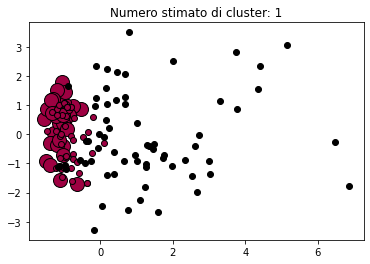

In [8]:
#mostriamo il risultato avuto con dbscan
# Rimuoviamo il nero per usarlo solo per il rumore.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Usiamo il nero per indicare il rumore.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = pca_df[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = pca_df[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    
#Mostriamo il grafico e i valori utili per analizzarlo
print("Coefficiente di forma: %0.3f" % metrics.silhouette_score(pca_df, labels))
print("Punti di rumore presenti:", n_noise_)
plt.title('Numero stimato di cluster: %d' % n_clusters_)
plt.show()

In [9]:
#mostra il dataset modificato dopo l'applicazione di PCA
pca_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.329752,-0.283067,-1.191493,-0.808861,0.011832,-0.965002,1.461538,-0.441270,-0.352317,0.395732,-0.658013,-1.042979,-0.087482,-0.500229,0.360286,0.181114
1,-1.176551,1.229675,-0.168666,-0.329713,0.278480,0.665319,-0.501560,-0.098769,1.870507,0.032216,-1.378033,-0.698150,-0.067620,-0.325272,0.373712,0.099283
2,-1.052102,1.775833,1.173072,0.507716,0.285520,-1.119558,0.685280,0.084860,-0.085238,-0.830992,0.565611,-0.691889,0.314071,-0.633164,0.291117,0.078093
3,-1.169983,-1.107921,-0.800924,-0.373139,-0.413032,-0.094924,-1.316333,1.337622,-0.459366,-0.512471,-0.929045,0.958948,-0.066280,0.962373,0.047689,-0.056700
4,2.680419,-1.985333,0.894844,3.437432,0.062319,0.034347,0.865593,1.495826,0.676819,-0.378976,-0.109196,-0.769668,1.202251,-0.322530,0.176226,-0.157246


[Text(0.5, 0, 'K'),
 Text(0, 0.5, 'sum of squared distances'),
 Text(0.5, 1.0, 'Elbow graph')]

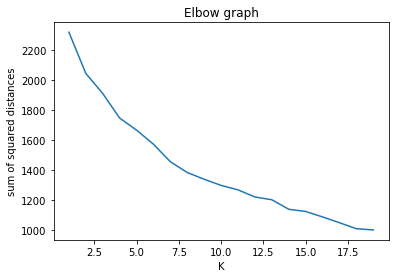

In [10]:
#calcola la somma degli errori quadrati per valutare
#il valore di k da utilizzare per il kmeans
#utilizziamo il metodo del gomito per determinare il valore di k
sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pca_df)
    sum_of_squared_distances.append(km.inertia_)
    
ax = sns.lineplot(x=K, y = sum_of_squared_distances)
ax.set(xlabel='K', ylabel='sum of squared distances', title='Elbow graph')

In [11]:
#Trovato il numero di cluster ideali possiamo eseguire il k-means
kmeans = KMeans(n_clusters=4)    
kmeans.fit(pca_df)
y_kmeans = kmeans.predict(pca_df)
labels = kmeans.labels_

KMeans(n_clusters=4)

Coefficiente di forma: 0.084


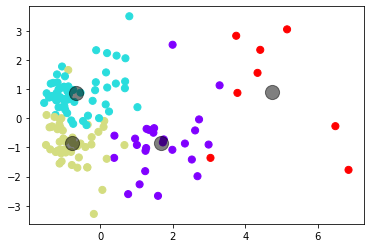

In [12]:
#mostriamo come sono stati formati i cluster
plt.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1], c=y_kmeans, s=50, cmap='rainbow')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
dataset = pca_df
#i pallini neri rappresentano i centroidi
print("Coefficiente di forma: %0.3f" % metrics.silhouette_score(pca_df, labels))

In [13]:
#Creiamo un dizionario per memorizzare le associazioni istanza - cluster
kmeans_dic = []

#Recuperiamo e memorizziamo le associazioni 
for c_row in range(len(dataset)):
    kmeans_dic.append({"id": c_row + 1, "cluster_id": labels[c_row]})

#visualizziamo le coppie tupla - cluster    
kmeans_dic

[{'id': 1, 'cluster_id': 2},
 {'id': 2, 'cluster_id': 1},
 {'id': 3, 'cluster_id': 1},
 {'id': 4, 'cluster_id': 2},
 {'id': 5, 'cluster_id': 0},
 {'id': 6, 'cluster_id': 2},
 {'id': 7, 'cluster_id': 1},
 {'id': 8, 'cluster_id': 2},
 {'id': 9, 'cluster_id': 1},
 {'id': 10, 'cluster_id': 1},
 {'id': 11, 'cluster_id': 1},
 {'id': 12, 'cluster_id': 1},
 {'id': 13, 'cluster_id': 1},
 {'id': 14, 'cluster_id': 1},
 {'id': 15, 'cluster_id': 1},
 {'id': 16, 'cluster_id': 0},
 {'id': 17, 'cluster_id': 0},
 {'id': 18, 'cluster_id': 0},
 {'id': 19, 'cluster_id': 2},
 {'id': 20, 'cluster_id': 1},
 {'id': 21, 'cluster_id': 1},
 {'id': 22, 'cluster_id': 1},
 {'id': 23, 'cluster_id': 1},
 {'id': 24, 'cluster_id': 1},
 {'id': 25, 'cluster_id': 1},
 {'id': 26, 'cluster_id': 1},
 {'id': 27, 'cluster_id': 1},
 {'id': 28, 'cluster_id': 0},
 {'id': 29, 'cluster_id': 2},
 {'id': 30, 'cluster_id': 3},
 {'id': 31, 'cluster_id': 2},
 {'id': 32, 'cluster_id': 2},
 {'id': 33, 'cluster_id': 1},
 {'id': 34, 'cluste

In [14]:
#leggiamo il file contenenti i lidi associati ad ogni cluster
#file costruito manualmente tenendo conto delle caratteristiche di ogni lido
#lidi_df = dataframe
lidi_df = pd.read_csv("C:\\fiaProject\lidi.txt", encoding='latin1')
lidi_df.head(5)
print('Tupla che rappresenta la dimensionalità del DataFrame:')
lidi_df.shape

,id_lido,nome,id_cluster
0,1,Marinella,1
1,2,Sole Mio,1
2,3,Virgola,1
3,4,Passeggero,1
4,5,Carminuccio,1


Tupla che rappresenta la dimensionalità del DataFrame:


(24, 3)

In [15]:
#ritorna il cluster in cui l'input utente è stato smistato dal k-means
def getClusterInputUtente(id, dic):
    id = id - 1
    for x in dic:
        if x['id'] == id:
            return x['cluster_id']

#ritorna la lista di lidi associati al cluster dato in input
def getLidiCluster(id):
    lidi = []
    for index, row in lidi_df.iterrows():
        if(row['id_cluster'] == id):
            lidi.append(row['nome'])
    return lidi    

In [16]:
#funzione che una volta ricevuti i nuovi dati esegue il kmeans
#per capire dove i nuovi dati sono stati inseriti
def eseguiClustering(df):
    #togliamo le colonne contenenti dati testuali per facilitare il calcolo
    stringless_df = df.drop(['Anni','Sesso','SituazioneSentim','Figli', 'Lavoro'], axis=1)
    stringless_df = stringless_df.dropna()

    #scala i dati per una migliore distribuzione
    X_std = StandardScaler().fit_transform(stringless_df)
    pca = PCA(n_components=.95)
    principalComponents = pca.fit_transform(X_std)

    #Applica l'analisi delle componeneti principali
    pca = PCA(n_components=16)
    principalComponents = pca.fit_transform(X_std)
    pca_df = pd.DataFrame(principalComponents)

    #calcola la somma degli errori quadrati per valutare
    #il valore di k da utilizzare per il kmeans
    sum_of_squared_distances = []
    K = range(1,20)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(pca_df)
        sum_of_squared_distances.append(km.inertia_)
    
    #ax = sns.lineplot(x=K, y = sum_of_squared_distances)
    #ax.set(xlabel='K', ylabel='sum of squared distances', title='Elbow graph')

    #Trovato il numero di cluster ideali possiamo eseguire il k-means
    kmeans = KMeans(n_clusters=4)    
    kmeans.fit(pca_df)
    y_kmeans = kmeans.predict(pca_df)
    labels = kmeans.labels_

    kmeans_dic = []

    # Recuperiamo le associazioni tra istanze e clusters
    for c_row in range(len(stringless_df)):
        kmeans_dic.append({"id": c_row + 1, "cluster_id": labels[c_row]})
    
    last_index = len(stringless_df)   
    
    id_cluster = getClusterInputUtente(last_index, kmeans_dic)
    
    lidi_trovati = getLidiCluster(id_cluster)
    return lidi_trovati

### Main dello script
Vengono mostrate all'utente alcune domande a cui rispondere, in base alle risposte date, l'algoritmo elabora i dati e suggerisce i possibili lidi balneari che potrebbero piacere all'utente.

In [17]:
#inizio main
#le domande poste all'utente
domande = ["Quanti anni hai?(14 o 15.21 o 22.30 o 30.40 o 40.50 o 50.60 o 60)"
           ,"Sesso?(m o f)"
           ,"Situazione Sentimentale?(Single o Sposata/o o Fidanzata/o o Divorziata/o)"
           ,"Figli minorenni? (s,n)"
           ,"Lavoro? (Studente o Operaio o LiberoProfessionista o Commerciante o Pensionato o Impiegato o Disoccupato)"
           ,"Usi gli Ombrelloni in spiaggia?(1 o 0)"
           ,"Vai al ristorante in spiaggia?(1 o 0)"
           ,"Usi la palestra in spiaggia?(1 o 0)"
           ,"Usi campi di gioco in spiaggia?(1 o 0)"
           ,"Usi il wi-fi in spiaggia?(1 o 0)"
           ,"Leggi giornali e affini in spiaggia?(1 o 0)"
           ,"Usi il parcheggio della spiaggia?(1 o 0)"
           ,"Usi l'animazione per bambini in spiaggia?(1 o 0)"
           ,"Fai attivita' di gruppo in spiaggia?(1 o 0)"
           ,"Usi la doccia in spiaggia?(1 o 0)"
           ,"Usi servizi come canoa e pedalo' in spiaggia?(1 o 0)"
           ,"Scegli il tuo lido in base ai prezzi?(1 o 0)"
           ,"Scegli il tuo lido in base alla vicinanza?(1 o 0)"
           ,"Scegli il tuo lido in base ai servizi che offre?(1 o 0)"
           ,"Scegli il tuo lido in base al meteo?(1 o 0)"
           ,"Scegli il tuo lido in base all'affluenza?(1 o 0)"]
risposte = []
tot_domande = len(domande)

print("Benvenuto su SorrentoMarina, ti porremo alcune domande semplici per capire i tuoi gusti. In base alle risposte"
          + "ti suggeriremo i lidi perfetti per te")
for i in range(tot_domande):
    print(domande[i])
    inp = input()
    if(inp is not None):
        if(inp == '0' or inp == '1'):
            num = int(inp)
            risposte.append(num)
        else:        
            risposte.append(inp)

print(risposte)

len_df = len(df)
df.loc[len_df] = risposte
lidi_scelti = eseguiClustering(df)

print("Abbiamo elaborato le tue risposte...Ecco i lidi che ti consigliamo:")
for i in range (len(lidi_scelti)):
    print('Lido ' + lidi_scelti[i]) 

Benvenuto su SorrentoMarina, ti porremo alcune domande semplici per capire i tuoi gusti. In base alle risposteti suggeriremo i lidi perfetti per te
Quanti anni hai?(14 o 15.21 o 22.30 o 30.40 o 40.50 o 50.60 o 60)
14
Sesso?(m o f)
m
Situazione Sentimentale?(Single o Sposata/o o Fidanzata/o o Divorziata/o)
Single
Figli minorenni? (s,n)
s
Lavoro? (Studente o Operaio o LiberoProfessionista o Commerciante o Pensionato o Impiegato o Disoccupato)
Studente
Usi gli Ombrelloni in spiaggia?(1 o 0)
1
Vai al ristorante in spiaggia?(1 o 0)
0
Usi la palestra in spiaggia?(1 o 0)
0
Usi campi di gioco in spiaggia?(1 o 0)
1
Usi il wi-fi in spiaggia?(1 o 0)
0
Leggi giornali e affini in spiaggia?(1 o 0)
1
Usi il parcheggio della spiaggia?(1 o 0)
1
Usi l'animazione per bambini in spiaggia?(1 o 0)
0
Fai attivita' di gruppo in spiaggia?(1 o 0)
1
Usi la doccia in spiaggia?(1 o 0)
1
Usi servizi come canoa e pedalo' in spiaggia?(1 o 0)
0
Scegli il tuo lido in base ai prezzi?(1 o 0)
1
Scegli il tuo lido in base 